This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['unique_data_identifier'] = df['unique_data_identifier']
  return encoded

In [3]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [4]:
encoded_data  = one_hot(all_data, "activity", "is")
X = pd.merge(all_data, encoded_data, on=["unique_data_identifier"])
Y = X["soc_delta"].to_numpy()
X.drop(columns=["soc_delta", "activity",  "id", "unique_data_identifier"], inplace=True)

In [5]:
# Split the data into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=43)

In [6]:
print(f"Length train_x = {len(train_X)} \n Length train_y = {len(train_y)}")

Length train_x = 1199 
 Length train_y = 1199


In [7]:
print(f"Length test_x = {len(test_X)} \n Length test_y = {len(test_y)}")

Length test_x = 514 
 Length test_y = 514


Machine Learning Model Implementation

In [8]:
from xgboost import XGBRegressor

# Create an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=30, max_depth=3, learning_rate=0.45)

# Train the model on the training data
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.45, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=30, ...)

In [9]:
# Make predictions using the testing set
y_pred = xgb_model.predict(test_X)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, train_X, train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 12  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, train_X, train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

Mean Squared Error (MSE): 0.6947332339209852
Coefficient of Determination (R-squared): 0.8946124733043735
Cross-validated R-squared: 0.896354264155111
Mean Absolute Error (MAE): 0.42012753456770285
Root Mean Squared Error (RMSE): 0.8335065890087403
K-fold Cross-validated R-squared: 0.9075377625087052


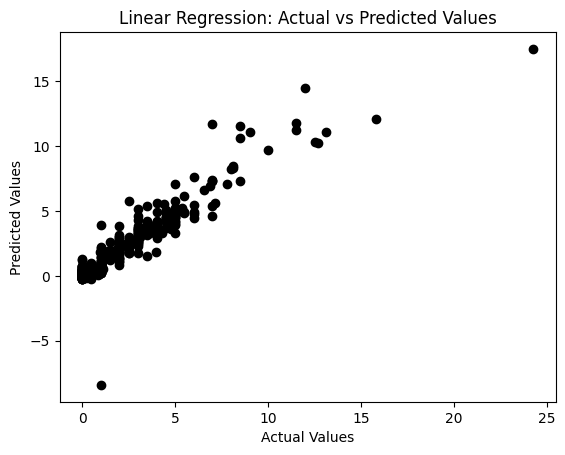

In [11]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted Values")

plt.show()

Feature Importances:
                        Feature  Importance
9             activity_is_climb    0.315550
0                    time_delta    0.222403
20          activity_is_takeoff    0.163393
2              average_altitude    0.104519
4                 average_power    0.085450
3                  ground_speed    0.075731
1                           soh    0.011708
5                   temperature    0.004694
7                    wind_speed    0.004278
17      activity_is_slow flight    0.003633
10           activity_is_cruise    0.002136
19      activity_is_steep turns    0.001921
14  activity_is_power off stall    0.001436
13      activity_is_post-flight    0.001298
15   activity_is_power on stall    0.000541
6                    visibility    0.000531
11          activity_is_descent    0.000392
8             activity_is_HASEL    0.000386
16       activity_is_pre-flight    0.000000
18       activity_is_steep turn    0.000000
12          activity_is_landing    0.000000


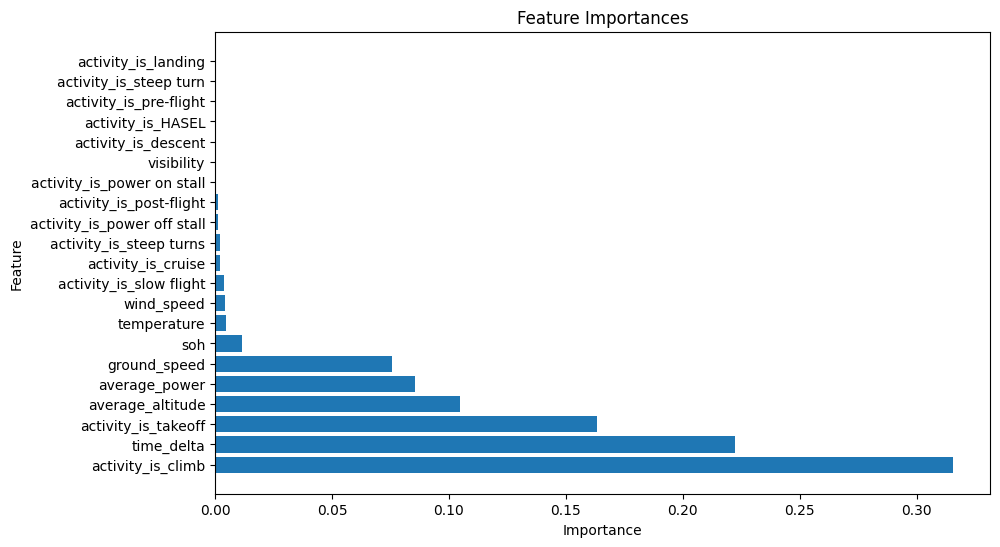

In [12]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get the corresponding feature names
feature_names = train_X.columns

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [13]:
import joblib

model_filename = 'ML_model_outputs/prescription_xgboost_model.joblib'
joblib.dump(xgb_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ML_model_outputs/prescription_xgboost_model.joblib
